# Rectify
Does using "normalized" mean state improve RO's ability to simulate mean state? Based on this reference:  
Huang, P., Chen, Y., Li, J. & Yan, H. "Redefined background state in the tropical Pacific resolves the entanglement between the background state and ENSO". *npj Clim Atmos Sci* 7, 147 (2024).

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os
import scipy.stats
import copy
from sklearn.preprocessing import PowerTransformer

# Import custom modules
from src.XRO import XRO, xcorr
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def plot_pdf(ax, x, edges, **plot_kwargs):
    """Plot empirical PDF on given ax for specified data (x),
    using specified edges for histogram"""

    ## compute pdf, skewness, and gaussian best fit
    pdf, _ = src.utils.get_empirical_pdf(x, edges=edges)
    skew = scipy.stats.skew(x)
    pdf_gauss, pdf_gauss_pts = src.utils.get_gaussian_best_fit(x)

    ## plot pdf
    ax.stairs(pdf, edges, lw=1.5, label=f"skew = {skew:.2f}", **plot_kwargs)

    ## plot gaussian best fit
    ax.plot(pdf_gauss_pts, pdf_gauss, c="k", lw=1)

    ## label and hide yticks
    ax.legend(prop=dict(size=7))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim([-4.25, 4.25])

    return ax


def label_ac_ax(ax):
    """add labels to growth rate annual cycle plot (ax object)"""

    ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
    ax.axhline(0, c="k", ls="-", lw=0.5)
    ax.set_xticks([1, 8, 12], labels=["Jan", "Aug", "Dec"])

    return

## Load data

In [3]:
## should we use ORAS data?
use_oras = False
model = "cesm"

if use_oras:

    ## ORAS5 reanalysis (use as benchmark)
    oras_load_fp = pathlib.Path(DATA_FP, "XRO_indices_oras5.nc")
    Th = xr.open_dataset(oras_load_fp)

    ## rename variables for consistency and trim so time periods covered are the same
    Th = Th[["Nino34", "WWV"]].rename({"Nino34": "T", "WWV": "h"})

elif model == "mpi":

    ## MPI data
    mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
    Th = xr.open_dataset(mpi_load_fp)

    ## rename variables for consistency and trim so time periods covered are the same
    Th = Th.sel(time=slice("1979", "2024")).rename({"T_34": "T"})

    ## arbitrary scaling to match ORAS...
    Th["h"] *= 4

else:
    ## CESM data
    cesm_load_fp = pathlib.Path(DATA_FP, "cesm1_le", "cesm-le_all.nc")
    Th = xr.open_dataset(cesm_load_fp).rename({"member_idx": "member"})
    Th = Th.sel(time=slice("1979", "2024")).isel(member=slice(None, -2))

    ## remove ensemble mean
    Th = Th - Th.mean("member")

## Preprocessing (non-dimensionalize and box-cox if desired

In [4]:
## should we box-cox transform the mean?
remove_bc_mean = False

## non-dimensionalize
normalize = lambda x: x / x.std()
for n in ["T", "h"]:
    Th[f"{n}_norm"] = normalize(Th[n])

## box-cox transformation of data
X = src.XRO._convert_to_numpy(Th[["T_norm", "h_norm"]]).reshape(2, -1).T
pt = PowerTransformer()
pt.fit(X)
X_tilde = pt.transform(X)

## get normalized mean
norm_mean = pt.inverse_transform(X_tilde.mean(0, keepdims=True)).flatten()

## put transformed data back in correct shape
dims = "time" if use_oras else ("member", "time")
X_tilde = X_tilde.T.reshape(2, *Th["T"].shape)

## get transformed data
Th = Th.assign(dict(T_bc=(dims, X_tilde[0])))
Th = Th.assign(dict(h_bc=(dims, X_tilde[1])))

## subtract box-cox mean if desired...
if remove_bc_mean:
    Th["T_norm"].values = Th["T_norm"].values - norm_mean[0]
    Th["h_norm"].values = Th["h_norm"].values - norm_mean[1]

    # Th["T_norm"].values = X_tilde[0]
    # Th["h_norm"].values = X_tilde[1]

## PDFs

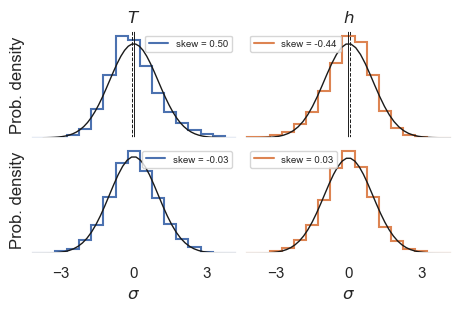

In [5]:
## specify edges for PDF and plotting colors
edges = np.arange(-4.25, 4.75, 0.5)
colors = sns.color_palette()[:2]

## function to get plot data
get_data = lambda x: x.isel(time=slice(None, None, None)).values.flatten()

## set-up plot
fig, axs = plt.subplots(2, 2, figsize=(4.5, 3), layout="constrained")

## plot data
plot_pdf(axs[0, 0], get_data(Th["T_norm"]), edges=edges, color=colors[0])
plot_pdf(axs[0, 1], get_data(Th["h_norm"]), edges=edges, color=colors[1])
plot_pdf(axs[1, 0], get_data(Th["T_bc"]), edges=edges, color=colors[0])
plot_pdf(axs[1, 1], get_data(Th["h_bc"]), edges=edges, color=colors[1])

## plot means
kwargs = dict(lw=0.7, c="k")
for j in [0, 1]:
    axs[0, j].axvline(0, ls="-", **kwargs)
    axs[0, j].axvline(norm_mean[j], ls="--", **kwargs)

## label plot
axs[0, 0].set_title(r"$T$")
axs[0, 1].set_title(r"$h$")
for j in [0, 1]:
    axs[j, 0].set_ylabel("Prob. density")
for j in [0, 1]:
    axs[1, j].set_xticks([-3, 0, 3])
    axs[1, j].set_xlabel(r"$\sigma$")
plt.show()

## Fit RO model

In [6]:
## specify order of annual cycle
ac_order = 3

## specify which parameters to mask annual cycle out for [(y_idx0, x_idx0), ...]
ac_mask_idx = [(1, 1)]

## initialize model
model = XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit for reanalysis
fit = model.fit_matrix(Th[["T_norm", "h_norm"]], ac_mask_idx=ac_mask_idx)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


## Plot RO parameters

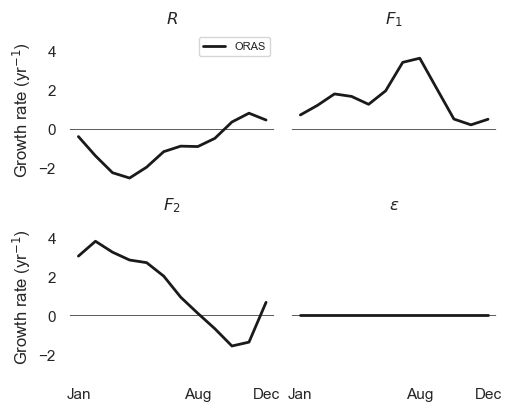

In [7]:
## Get parameters for ORAS and MPI
params = model.get_RO_parameters(fit).rename({"cycle": "month"})

## get labels of parameters for plotting
labels = [r"$R$", r"$F_1$", r"$F_2$", r"$\epsilon$"]
var_names = ["R", "F1", "F2", "epsilon"]

## set up plot
fig, axs = plt.subplots(2, 2, figsize=(5, 4), layout="constrained")

## separate plo for each set of parameters
for i, (ax, label, n) in enumerate(zip(axs.flatten(), labels, var_names)):

    ### plot seasonal cycle parameter for each
    plot_kwargs = dict(c="k", ls="-", lw=2, label="ORAS")
    ax.plot(params.month, params[n], **plot_kwargs)
    ax.set_title(label)
    ax.set_ylim([-3, 5])
    label_ac_ax(ax)

## make plot less clustered
for ax in axs[0, :]:
    ax.set_xlabel(None)
    ax.set_xticks([])
for ax in axs[:, 1]:
    ax.set_ylabel(None)
    ax.set_yticks([])
for ax in axs[:, 0]:
    ax.set_yticks([-2, 0, 2, 4])

axs[0, 0].legend(prop=dict(size=8))
plt.show()

## Look at residuals

### Compute actual/predicted time derivative

In [8]:
## compute time derivatives for T and h
Th_np = src.XRO._convert_to_numpy(Th[["T_norm", "h_norm"]])
dx_dt = src.XRO.gradient(Th_np)

## get dims
dims = ("time") if use_oras else ("member", "time")

## add to dataset
Th = Th.assign(dict(dT_dt=(dims, dx_dt[0]), dh_dt=(dims, dx_dt[1])))

## Pull out T and h vars for convenience
T = copy.deepcopy(Th["T_norm"])
h = copy.deepcopy(Th["h_norm"])

## compute terms in RO
RT = params["R"] * T.groupby("time.month")
F1h = params["F1"] * h.groupby("time.month")
F2T = params["F2"] * T.groupby("time.month")
epsilonh = params["epsilon"] * T.groupby("time.month")

## swap dims again (to make shapes work...)
if not (use_oras):
    dims = dims[::-1]

## put in xarray
Th = Th.assign(
    dict(
        RT=(dims, RT.data),
        F1h=(dims, F1h.data),
        F2T=(dims, F2T.data),
        epsilonh=(dims, epsilonh.data),
    )
)

## get actual residuals
res = xr.merge(
    [
        (Th["dT_dt"] - Th["F1h"]).rename("RT"),
        (Th["dT_dt"] - Th["RT"]).rename("F1h"),
        (Th["dh_dt"] + Th["epsilonh"]).rename("F2T"),
        (Th["dh_dt"] + Th["F2T"]).rename("epsilonh"),
    ]
)

### Compute and plot residuals

In [9]:
def plot_residual(ax, term, Th_data, res_data, params, month, **plot_kwargs):
    """plot residual for term on ax object"""

    ## extract parameter and variable name
    param_name = term[:-1]
    var_name = f"{term[-1]}_norm"

    ## extract parameter
    param = params[param_name].sel(month=m).values.item()

    ## make sure sign is correct
    if param_name in ["F2", "epsilon"]:
        param = -param

    ## plot data
    ax.scatter(
        selmon(Th_data[var_name], m=month).values.flatten(),
        selmon(res_data[term], m=month).values.flatten(),
        label="residual",
        **plot_kwargs,
    )

    ## plot best fit line
    test_pts = np.linspace(-2, 2.5)
    ax.plot(test_pts, param * test_pts, c="k", lw=1.5, label="predicted")

    ## label
    ax.axvline(0, c="k", lw=0.5)
    ax.axhline(0, c="k", lw=0.5)
    ax.set_ylim([-22, 22])
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

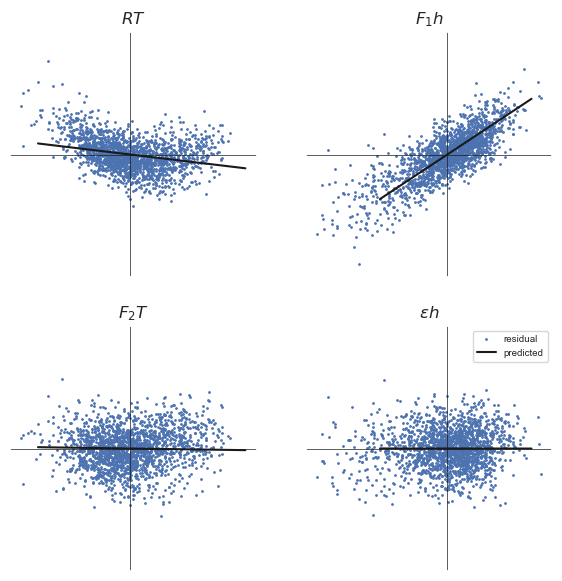

In [10]:
## specify month for plotting
m = 8

## function to select month
selmon = lambda x, m: x.sel(time=(x.time.dt.month == m))

## get plotting params
s = 20 if use_oras else 1
ylim = 12 if use_oras else 20

## set up plot
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

kwargs = dict(Th_data=Th, res_data=res, params=params, month=m, s=s)

## plot data
plot_residual(axs[0, 0], term="RT", **kwargs)
plot_residual(axs[0, 1], term="F1h", **kwargs)
plot_residual(axs[1, 0], term="F2T", **kwargs)
plot_residual(axs[1, 1], term="epsilonh", **kwargs)

## add titles
for t, ax in zip([r"$RT$", r"$F_1h$", r"$F_2T$", r"$\epsilon h$"], axs.flatten()):
    ax.set_title(t)
    ax.set_ylim([-ylim, ylim])

axs[1, 1].legend(prop=dict(size=7))

plt.show()

Make this plot for change over time!!!